# Project 01 - Image Registration

Done by: Diana Petrusheva and Mohamed Asker

In [2]:
import numpy as np
import cv2 
import skimage as sk
import matplotlib.pyplot as plt
import os
from skimage import io
from skimage.transform import AffineTransform
import random
from sklearn.linear_model import LinearRegression
from PIL import Image, ImageOps

In [3]:
def plot_two(img1, img2, size=12):
    plt.figure(figsize=(size,size))
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap='gray')
    plt.show()

### 0. Load images

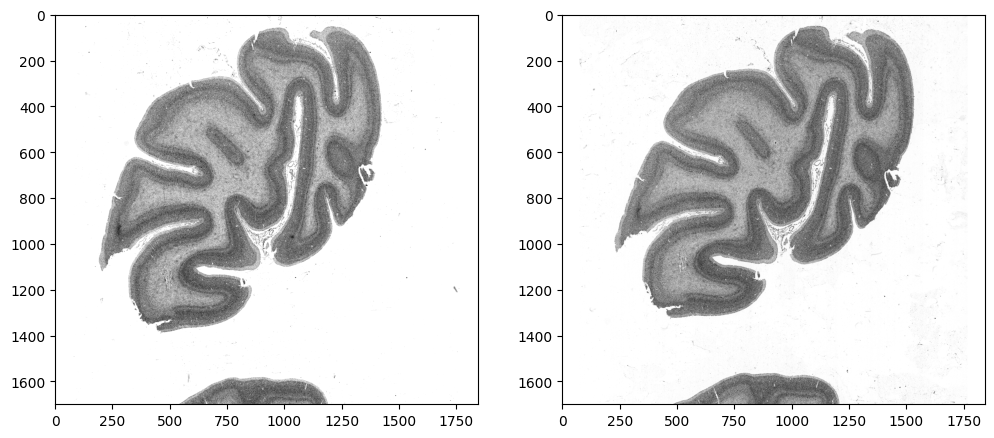

In [5]:
filename1 = os.path.join('./png', 'B20_0431.png')
filename2 = os.path.join('./png', 'B20_0432.png')
#read an image
brain1 = cv2.imread(filename1, cv2.IMREAD_GRAYSCALE) 
brain2 = cv2.imread(filename2, cv2.IMREAD_GRAYSCALE)
#1844, 1599 max, min dimension in the dataset
brain1 = cv2.copyMakeBorder(brain1,0,0,(1844 - brain1.shape[1])//2,(1844- brain1.shape[1])//2, cv2.BORDER_CONSTANT,value= [255,255,255])
brain2 = cv2.copyMakeBorder(brain2,0,0,(1844 - brain2.shape[1])//2,(1844- brain2.shape[1])//2, cv2.BORDER_CONSTANT,value= [255,255,255])
# print(brain1_p.shape, brain2_p.shape)
plot_two(brain1, brain2)

### 1. Detecting image features using SIFT algorithm. <br>
The function finds the keypoints and their descriptors of the given image and returns them along with the image with its drawn keypoints, which is saved under the path kp_img_path. 

In [7]:
N_FEATURES = 5000

def sift_detect_features(img, kp_img_path):
    sift = cv2.SIFT_create(nfeatures=N_FEATURES)
    kp, desc = sift.detectAndCompute(img,None)
    kp_img = cv2.drawKeypoints(img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # cv2.imwrite(kp_img_path, kp_img)
    return kp, desc, kp_img

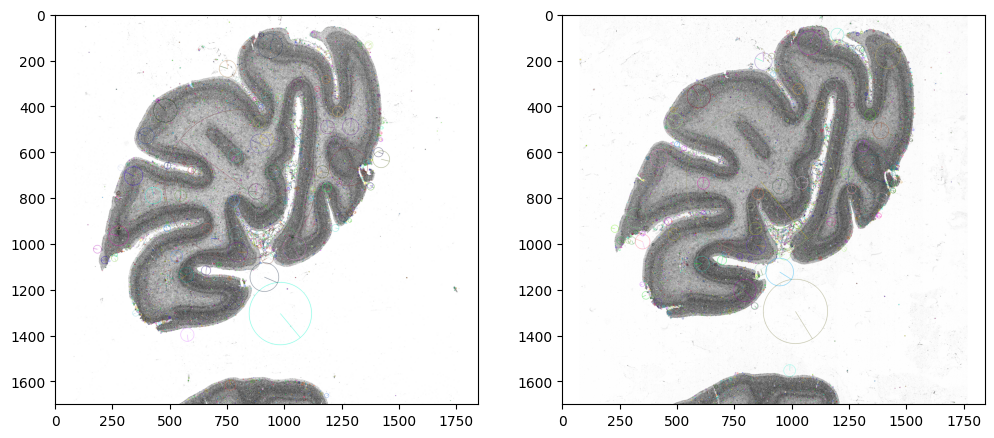

In [8]:
kp_brain1, desc_brain1, kp_img_brain1 = sift_detect_features(brain1, 'brain1_sift_keypoints.jpg')
kp_brain2, desc_brain2, kp_img_brain2 = sift_detect_features(brain2, 'brain2_sift_keypoints.jpg')

plot_two(kp_img_brain1, kp_img_brain2)

### 2. Matching the features using Brute_force Matcher algorithm.<br>
The function gets as parameters two images, their feature descriptors, their keypoints and a distance threshold. <br>
One feature from the first image is matched with every feature from the second using distance calculation and the closest one is taken. A match is considered valid if the distance to the closest feature descriptor in the second array is less than distance_threshold times the distance to the second closest feature descriptor.<br>
The keypoints and the images parameters are only used for visualization. The function returns a list with all the matches and an object of type drawMatches for visualization.

In [9]:
# Brute force feature matching using euclidean distance.
# It uses feature descriptors to find the closest features from . 
# The images and the keypoints are used only for visualization.
# A match is considered valid if the distance to the closest feature descriptor in the second array is less than distance_threshold times the distance to the second closest feature descriptor. 
def bf_matcher(img1, img2, feature_descriptor1, feature_descriptor2, kp1, kp2, distance_threshold=0.50):
    
    matches = []

    for i in range(feature_descriptor1.shape[0]):
        distances = np.linalg.norm(feature_descriptor2 - feature_descriptor1[i], axis=1)
        distances_sorted_idx = np.argsort(distances)
        closest_dist = distances[distances_sorted_idx[0]]
        second_closest_idx = distances[distances_sorted_idx[1]]
        if closest_dist < distance_threshold * second_closest_idx:
            matches.append(cv2.DMatch(i, distances_sorted_idx[0], closest_dist))

    #can I use the DMatch object?
    #sort by distance
    matches = sorted(matches, key = lambda x: x.distance)
    return matches, cv2.drawMatches(img1 = img1,
                                        keypoints1 = kp1,
                                        img2 = img2,
                                        keypoints2 = kp2,
                                        matches1to2 = matches[:50],
                                        outImg = None,
                                        flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)



78


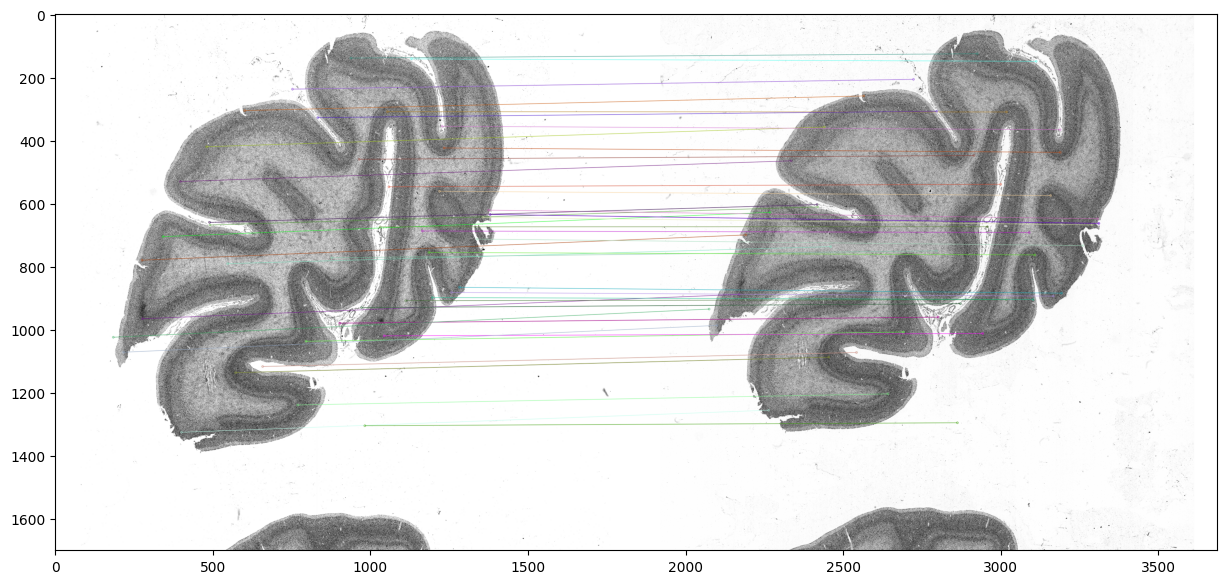

In [10]:
matches, draw_matches = bf_matcher(brain1, brain2, desc_brain1, desc_brain2, kp_brain1, kp_brain2,)
print(len(matches))
plt.figure(figsize=(15,15))
plt.imshow(draw_matches)
plt.show()

### 3. RANSAC: Removing outliers/taking the best inliers. <br>
RANSAC (Random sample consensus) is an algorithm for finding the best inliers trying to fit a model to randomly sampled matches. The inliers who are in the model with the largest number of inliers are returned. <br>
The model used in the following implementation is Linear Regression. It samples two matches randomly, fits the model according to them and checks how many matches lie in distance "threshold" or less from the model.<br>
The implementation tries to find the best inliers for a maximum of max_iterations. If a number of "min_inliers" or more inliers is found before that, exit earlier.

In [11]:
def RANSAC(matches, features_descriptor1, features_descriptor2, threshold = 10, max_iterations = 1000, min_inliers = 20):
    best_inliers = []
    for i in range(max_iterations):
        subset = random.sample(matches,3)
        X1 = np.float32([features_descriptor1[m.queryIdx] for m in subset]).reshape(-1,2)
        X2 = np.float32([features_descriptor2[m.trainIdx] for m in subset]).reshape(-1,2)
        
        model = LinearRegression().fit(X1,X2)

        #distances = []
        inliers = []
        for m in matches:
            x1 = np.float32(features_descriptor1[m.queryIdx]).reshape(-1,2)
            x2 = np.float32(features_descriptor2[m.trainIdx]).reshape(-1,2)
            x1_transformed = model.predict(x1)
            dist = np.linalg.norm(x1_transformed - x2)
            if dist < threshold:
                inliers.append(m)

        # check if the current model is better than the best one so far (i.e. with more inliers)
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
        
        # exit earlier if we have found enough inliers for our model
        if len(best_inliers) >= min_inliers:
            break
    
    return best_inliers

In [12]:
best_inliers = RANSAC(matches, desc_brain1, desc_brain2, threshold = 55, min_inliers = 20)
print(best_inliers[:10])
len(best_inliers)


[< cv2.DMatch 000001C82F596870>, < cv2.DMatch 000001C82F595BB0>, < cv2.DMatch 000001C82F5969F0>, < cv2.DMatch 000001C82F5967F0>, < cv2.DMatch 000001C82F5958F0>, < cv2.DMatch 000001C82F596070>, < cv2.DMatch 000001C82F596390>, < cv2.DMatch 000001C82F596310>, < cv2.DMatch 000001C82F596630>, < cv2.DMatch 000001C82F5966D0>]


14

In [13]:
print(best_inliers[0].distance)


29.051677703857422


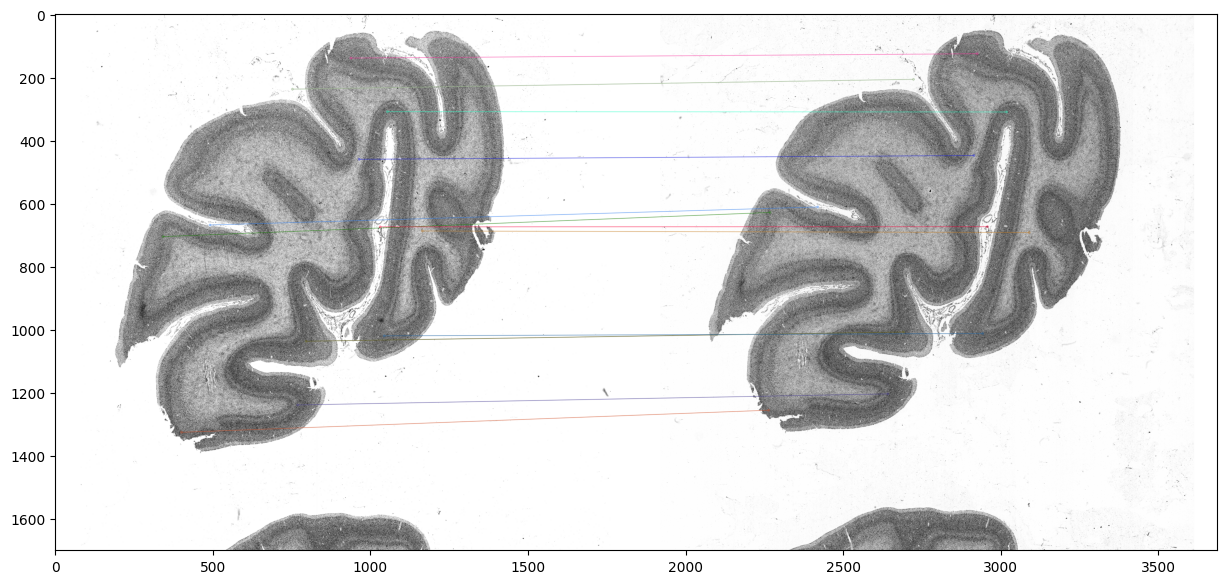

In [14]:
draw = cv2.drawMatches(img1 = brain1, 
                       keypoints1 = kp_brain1, 
                       img2 = brain2, 
                       keypoints2 = kp_brain2, 
                       matches1to2 = best_inliers, 
                       outImg = None, 
                       flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,15))
plt.imshow(draw)
plt.show()

### 4. Calculating the affine transformation. 

In [15]:
# I don't know if we can use the least-sqare method implemented in np.linalg

def calculate_affine_transformation_matrix(matches, features_descriptor1, features_descriptor2):

    X1 = np.float32([features_descriptor1[m.queryIdx].pt for m in matches]).reshape(-1,2)
    X2 = np.float32([features_descriptor2[m.trainIdx].pt for m in matches]).reshape(-1,2)

    X1 = np.flip(X1, axis=1)
    X2 = np.flip(X2, axis=1)

    #A = np.zeros((2*n, 6))
    #b = np.zeros((2*n, 1))
    X1_h = np.vstack([X1.T, np.ones((1, len(X1)))])
    X2_h = np.vstack([X2.T, np.ones((1, len(X2)))])
    # least_sqare solution to a linear matrix equation
    M, _, _, _ = np.linalg.lstsq(X1_h.T, X2_h.T, rcond=None)

    return M.T
    

In [16]:
affine_trans_matrix = calculate_affine_transformation_matrix(best_inliers, kp_brain1, kp_brain2)
affine_trans_matrix

array([[ 9.95537256e-01,  9.95658604e-02, -1.04896767e+02],
       [-9.79906397e-02,  1.00226441e+00,  1.48531039e+02],
       [ 6.13427380e-17, -5.61616725e-17,  1.00000000e+00]])

In [20]:
def apply_transformation(img, transformation):
    h, w = img.shape
    col1 = np.arange(h)
    col2 = np.arange(w)
    col1_full = np.tile(col1, w)
    col2_full = np.repeat(col2, h)
    points = np.column_stack((col1_full,col2_full))
    points_h = np.hstack((points, np.ones((points.shape[0], 1))))
    Xh_ = (transformation@points_h.T).T
    X_transformed = Xh_[:, :2]
    rounded_indices = X_transformed.astype(int).T
    points.astype(int)
    I_new = np.full(img.shape, 255)
    I_old = img
    x = np.clip(rounded_indices[0,:], 0, img.shape[0]-1)
    y = np.clip(rounded_indices[1,:], 0, img.shape[1]-1)
    # for i in range (rounded_indices.shape[1]):
    #     I_new[x[i], y[i]] = I_old[points[i][0], points[i][1]]
    I_new[x, y] = I_old[points[:, 0], points[:, 1]]
    return I_new   
    

In [21]:
I_new = apply_transformation(brain1, affine_trans_matrix)
cv2.imwrite('./test.png',I_new)

True

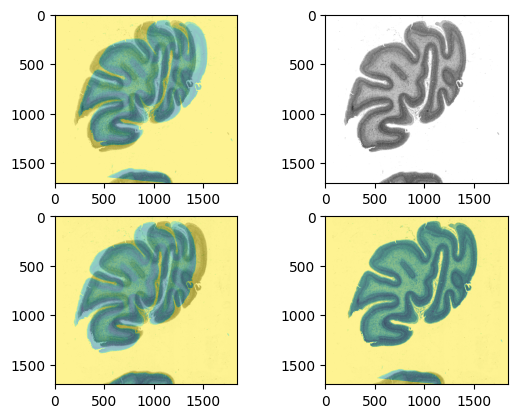

In [22]:
fig, axs = plt.subplots(2, 2)
#transformation on the original image
axs[0, 0].imshow(brain1, cmap='gray')
axs[0, 0].imshow(I_new, alpha = 0.5)
#nonsense
axs[0, 1].imshow(brain1, cmap='gray')
#old versions
axs[1, 0].imshow(brain2, cmap='gray')
axs[1, 0].imshow(brain1, alpha=0.5)
#new versions
axs[1, 1].imshow(brain2, cmap='gray')
axs[1, 1].imshow(I_new, alpha=0.5)
plt.show()


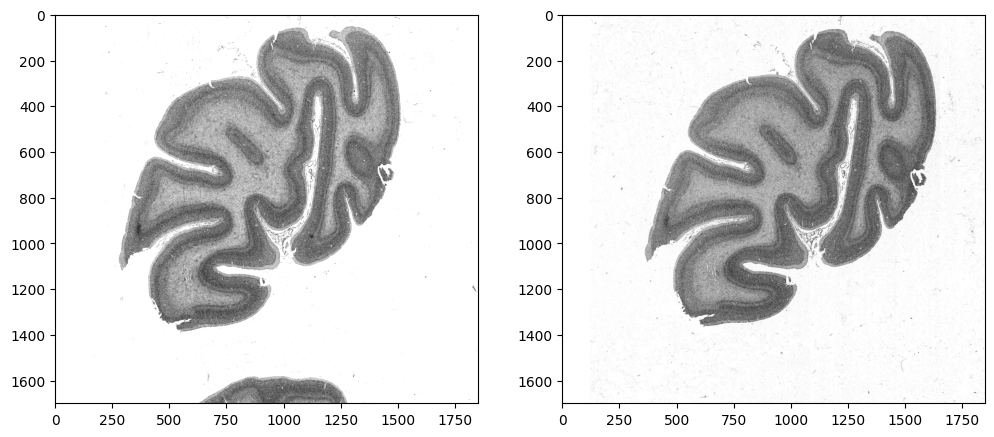

Number of Best inlier:  4


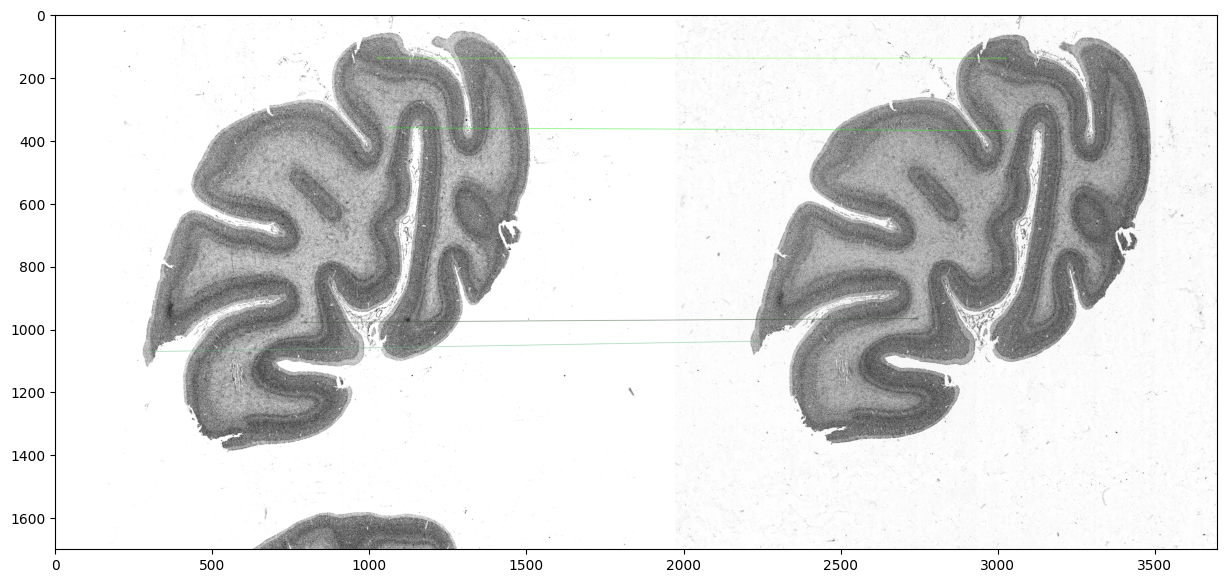

(1700, 1850)
(1700, 1850)


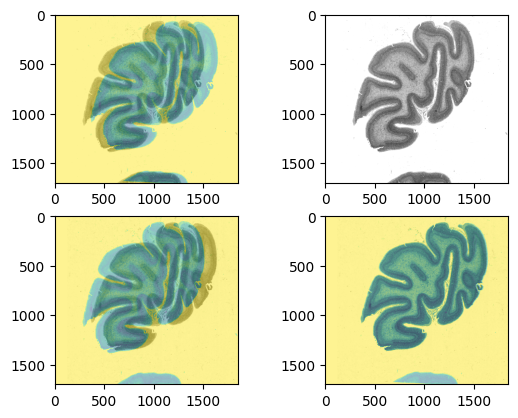

<Figure size 1500x1500 with 0 Axes>

In [19]:
#test1
filename1 = os.path.join('./png', 'B20_0431.png')
filename2 = os.path.join('./png', 'B20_0430.png')
#read an image
brain1 = cv2.imread(filename1, cv2.IMREAD_GRAYSCALE) 
brain2 = cv2.imread(filename2, cv2.IMREAD_GRAYSCALE)
#1844, 1599 max, min dimension in the dataset
brain1 = cv2.copyMakeBorder(brain1,0,0,np.int64(np.around((1850 - brain1.shape[1]))),0, 
                            cv2.BORDER_CONSTANT,value= [255])
# brain1 = cv2.copyMakeBorder(brain1,0,0,1,0, cv2.BORDER_CONSTANT,value= [255])

brain2 = cv2.copyMakeBorder(brain2,0,0,np.int64(np.around((1850 - brain2.shape[1]))),0,
                             cv2.BORDER_CONSTANT,value= [255])
plot_two(brain1, brain2)


kp_brain1, desc_brain1, kp_img_brain1 = sift_detect_features(brain1, 'brain1_sift_keypoints.jpg')
kp_brain2, desc_brain2, kp_img_brain2 = sift_detect_features(brain2, 'brain2_sift_keypoints.jpg')

#plot_two(kp_img_brain1, kp_img_brain2)

matches, draw_matches = bf_matcher(brain1, brain2, desc_brain1, desc_brain2, kp_brain1, kp_brain2, distance_threshold=0.6)
# plt.figure(figsize=(15,15))
# plt.imshow(draw_matches)
# plt.show()

best_inliers = RANSAC(matches, desc_brain1, desc_brain2, threshold = 45, min_inliers = 4)
#print(best_inliers[:10])
print("Number of Best inlier: ", len(best_inliers))

draw = cv2.drawMatches(img1 = brain1, 
                       keypoints1 = kp_brain1, 
                       img2 = brain2, 
                       keypoints2 = kp_brain2, 
                       matches1to2 = best_inliers, 
                       outImg = None, 
                       flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,15))
plt.imshow(draw)
plt.show()

affine_trans_matrix = calculate_affine_transformation_matrix(best_inliers, kp_brain1, kp_brain2)
inv = np.linalg.pinv(affine_trans_matrix)
rows, cols = brain1.shape
#warp = cv2.warpPerspective(brain2, inv, (cols, rows))
print(brain1.shape)

I_new = apply_transformation(brain1, affine_trans_matrix)
print(I_new.shape)
fig, axs = plt.subplots(2, 2)
plt.figure(figsize=(15,15))
#transformation on the original image
axs[0, 0].imshow(brain1, cmap='gray')
axs[0, 0].imshow(I_new, alpha = 0.5)
#nonsense
axs[0, 1].imshow(brain1, cmap='gray')
#old versions
axs[1, 0].imshow(brain2, cmap='gray')
axs[1, 0].imshow(brain1, alpha=0.5)
#new versions
axs[1, 1].imshow(brain2, cmap='gray')
axs[1, 1].imshow(I_new, alpha=0.5)
plt.show()

#merge = np.uint8(brain2 * 0.5 + warp * 0.5)

#I_new = apply_transformation(brain1, affine_trans_matrix)
#cv2.imwrite('./test.png',I_new)
#plot_two(warp, merge)

# Images Registertion - Full algorithm

Number of Best inlier:  4
30 31


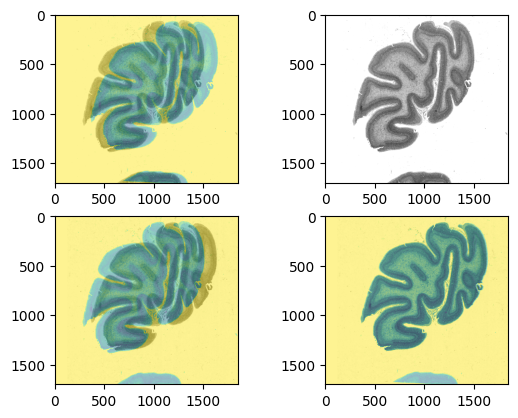

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  7
31 32


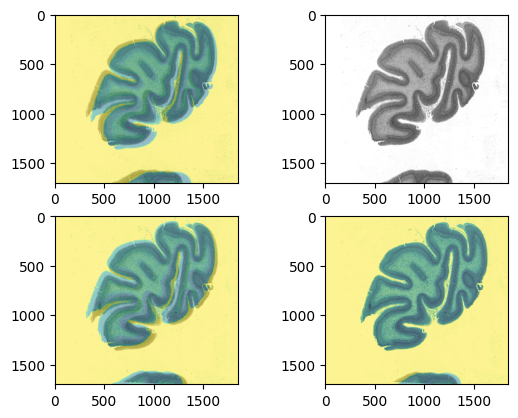

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  5
32 33


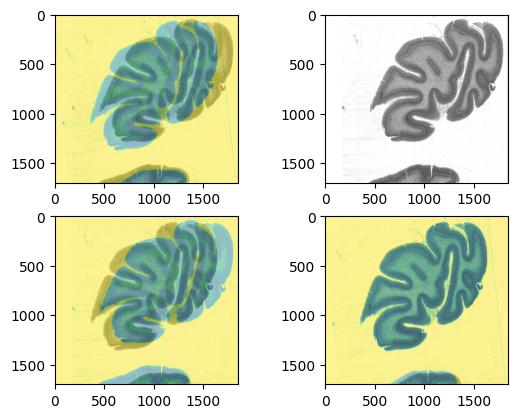

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  5
33 34


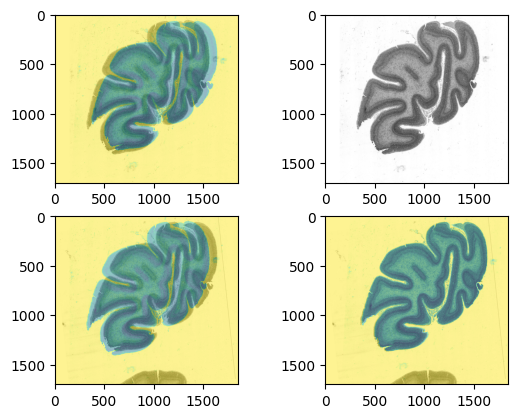

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  10
34 35


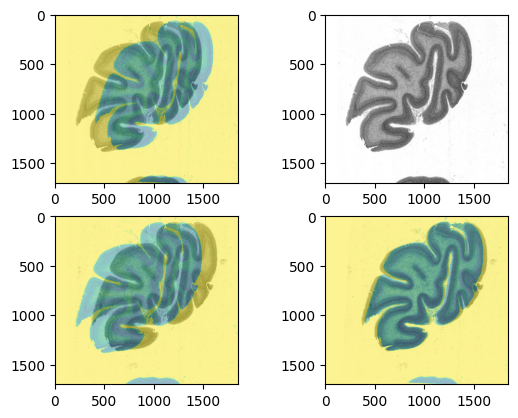

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  4
35 36


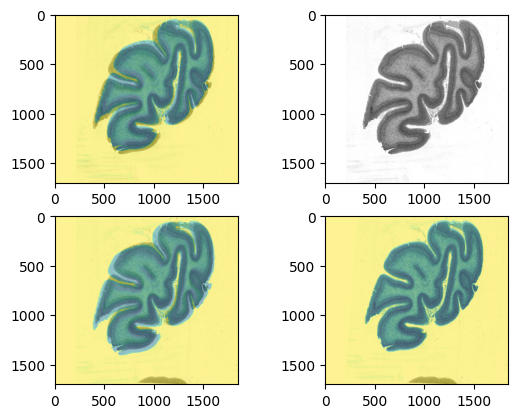

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  3
36 37


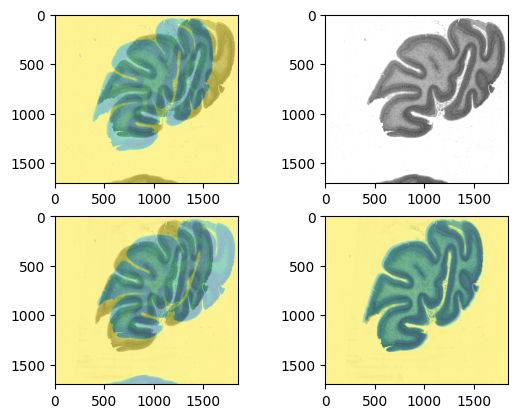

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  3
37 38


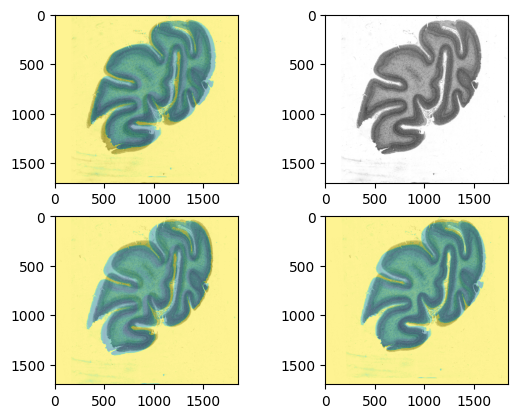

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  4
38 39


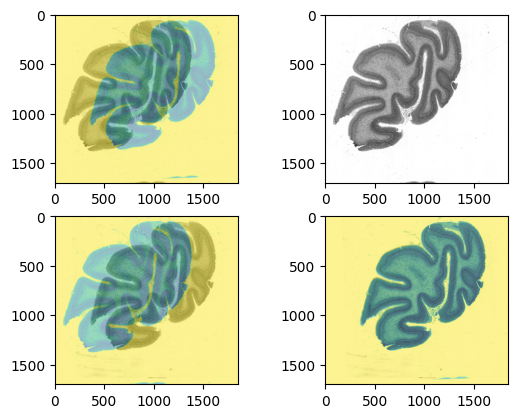

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  3
39 40


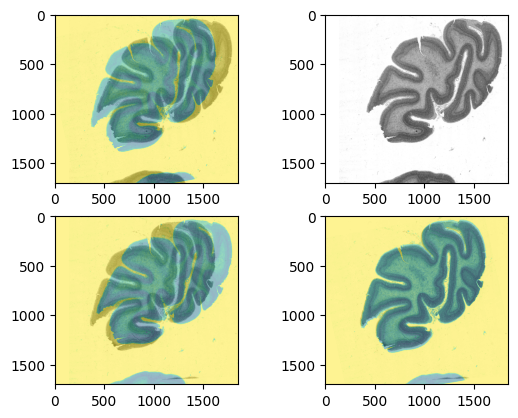

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  5
40 41


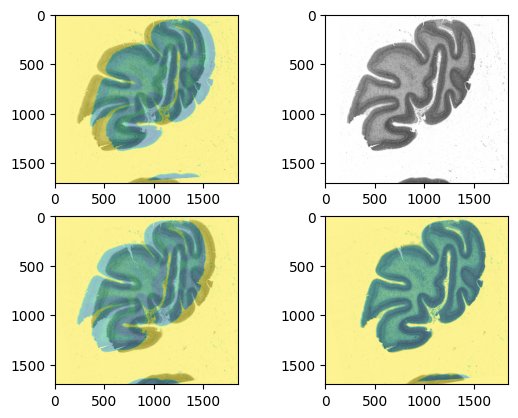

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  4
41 42


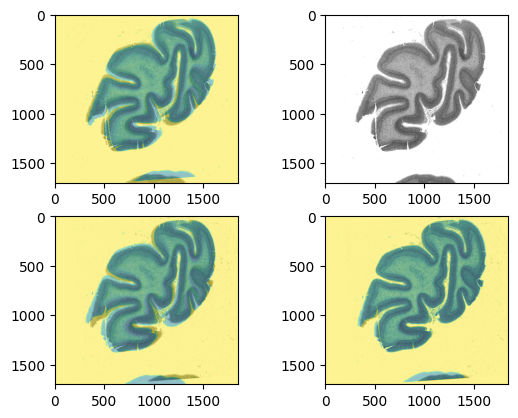

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  4
42 43


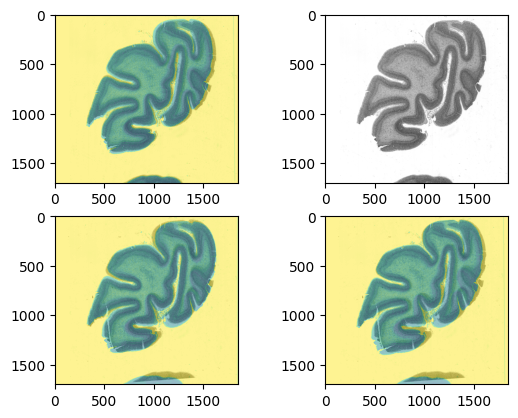

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  8
43 44


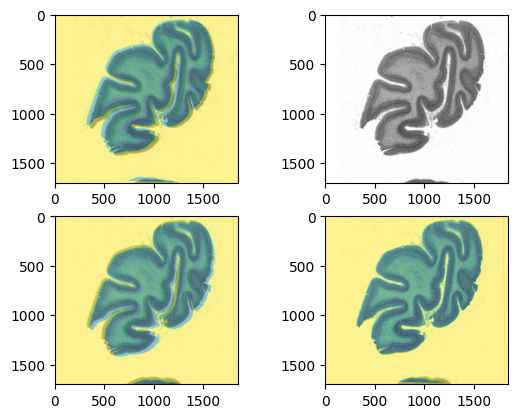

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  12
44 45


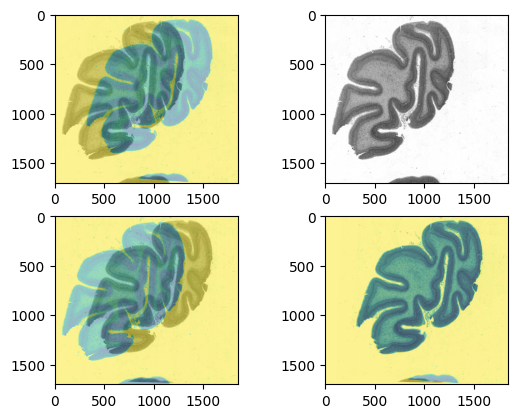

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  8
45 46


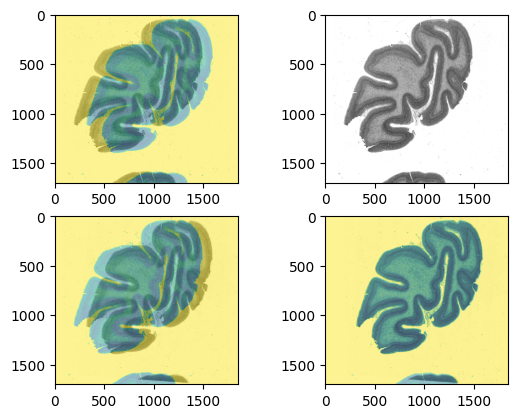

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  10
46 47


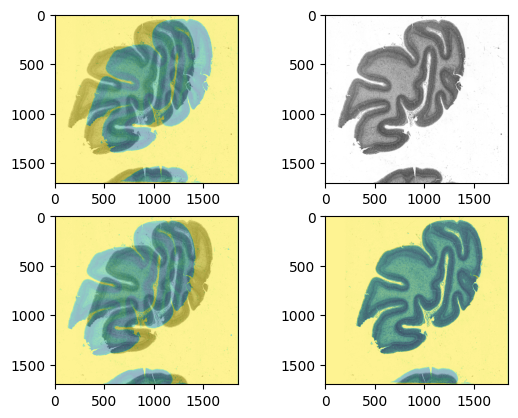

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  3
47 48


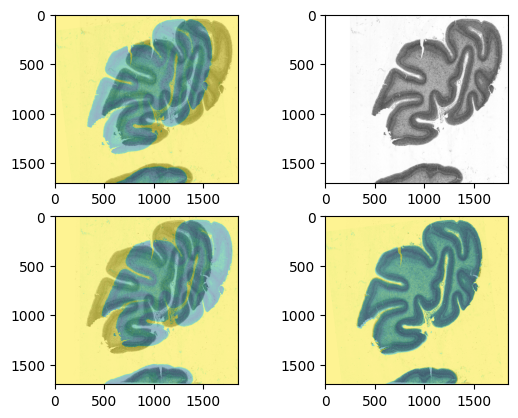

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  4
48 49


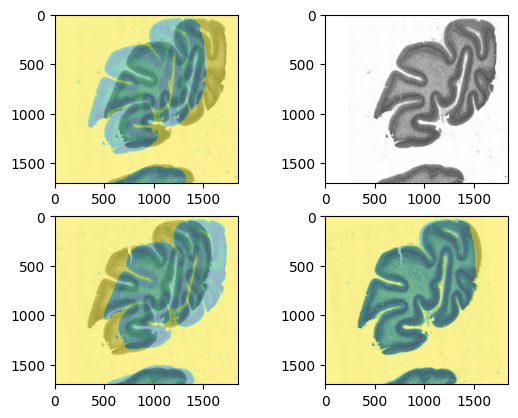

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  6
49 50


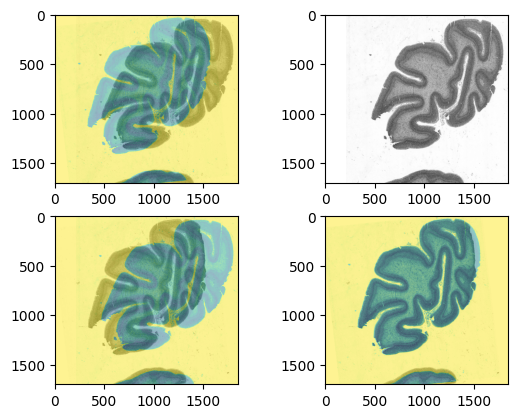

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  5
50 51


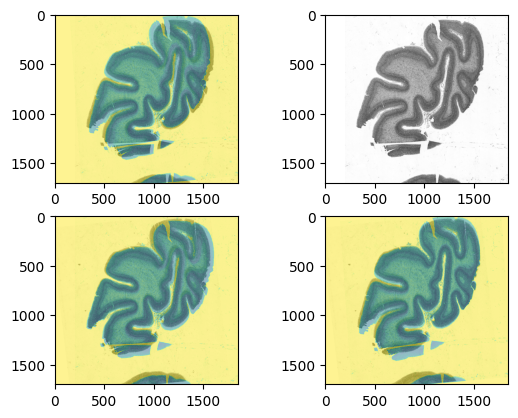

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  4
51 52


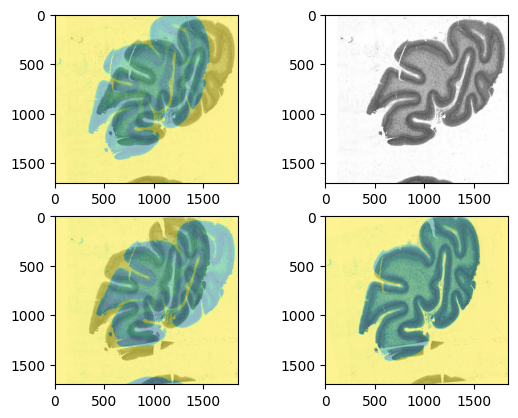

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  4
52 53


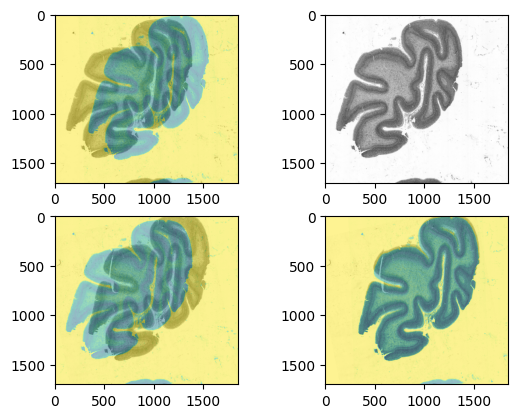

<Figure size 1500x1500 with 0 Axes>

Number of Best inlier:  4
53 54


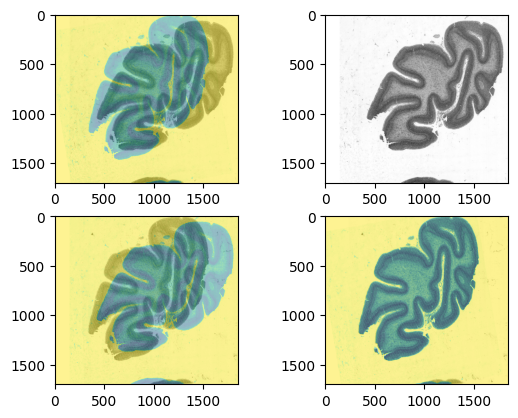

<Figure size 1500x1500 with 0 Axes>

In [22]:
for i in range(30, 55):
    brain1 = cv2.imread("./png/B20_04"+str(i+1)+".png", cv2.IMREAD_GRAYSCALE)
    brain1 = cv2.copyMakeBorder(brain1,0,0,np.int64(np.around((1850 - brain1.shape[1]))),0, 
                                cv2.BORDER_CONSTANT,value= [255])
    if i==30:
        brain2 = cv2.imread("./png/B20_04"+str(i)+".png", cv2.IMREAD_GRAYSCALE)
        brain2 = cv2.copyMakeBorder(brain2,0,0,np.int64(np.around((1850 - brain2.shape[1]))),0, 
                                cv2.BORDER_CONSTANT,value= [255])
    else:
        brain2 = I_new.copy()
        brain2 = cv2.copyMakeBorder(np.uint8(I_new),0,0,np.int64(np.around((1850 - I_new.shape[1]))),0, 
                                    cv2.BORDER_CONSTANT,value= [255])

    kp_brain1, desc_brain1, kp_img_brain1 = sift_detect_features(brain1, 'brain1_sift_keypoints.jpg')
    kp_brain2, desc_brain2, kp_img_brain2 = sift_detect_features(brain2, 'brain2_sift_keypoints.jpg')

    matches, draw_matches = bf_matcher(brain1, brain2, desc_brain1, desc_brain2, kp_brain1, kp_brain2, distance_threshold=0.5)

    best_inliers = RANSAC(matches, desc_brain1, desc_brain2, threshold = 45, min_inliers = 4)
    print("Number of Best inlier: ", len(best_inliers))

    affine_trans_matrix = calculate_affine_transformation_matrix(best_inliers, kp_brain1, kp_brain2)
    rows, cols = brain1.shape

    I_new = apply_transformation(brain1, affine_trans_matrix)
    cv2.imwrite('./transformed/b'+str(i)+'.png',I_new)
    print(i,i+1)
    fig, axs = plt.subplots(2, 2)
    plt.figure(figsize=(15,15))
    #transformation on the original image
    axs[0, 0].imshow(brain1, cmap='gray')
    axs[0, 0].imshow(I_new, alpha = 0.5)
    #nonsense
    axs[0, 1].imshow(brain1, cmap='gray')
    #old versions
    axs[1, 0].imshow(brain2, cmap='gray')
    axs[1, 0].imshow(brain1, alpha=0.5)
    #new versions
    axs[1, 1].imshow(brain2, cmap='gray')
    axs[1, 1].imshow(I_new, alpha=0.5)
    plt.show()
